<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-KITTI-데이터셋-확인" data-toc-modified-id="1.-KITTI-데이터셋-확인-1">1. KITTI 데이터셋 확인</a></span><ul class="toc-item"><li><span><a href="#1.1.-KITTI-데이터셋" data-toc-modified-id="1.1.-KITTI-데이터셋-1.1">1.1. KITTI 데이터셋</a></span></li><li><span><a href="#1.2.-데이터-직접-확인하기" data-toc-modified-id="1.2.-데이터-직접-확인하기-1.2">1.2. 데이터 직접 확인하기</a></span></li></ul></li><li><span><a href="#2.-keras-retinanet-학습" data-toc-modified-id="2.-keras-retinanet-학습-2">2. keras-retinanet 학습</a></span><ul class="toc-item"><li><span><a href="#2.1.-데이터-포맷-변경" data-toc-modified-id="2.1.-데이터-포맷-변경-2.1">2.1. 데이터 포맷 변경</a></span><ul class="toc-item"><li><span><a href="#클래스-및-바운딩-박스-정보-추출" data-toc-modified-id="클래스-및-바운딩-박스-정보-추출-2.1.1">클래스 및 바운딩 박스 정보 추출</a></span></li><li><span><a href="#클래스-맵핑" data-toc-modified-id="클래스-맵핑-2.1.2">클래스 맵핑</a></span></li></ul></li><li><span><a href="#2.2.-학습" data-toc-modified-id="2.2.-학습-2.2">2.2. 학습</a></span></li><li><span><a href="#2.3.-시각화" data-toc-modified-id="2.3.-시각화-2.3">2.3. 시각화</a></span></li></ul></li><li><span><a href="#3.-자율주행-보조-시스템-만들기" data-toc-modified-id="3.-자율주행-보조-시스템-만들기-3">3. 자율주행 보조 시스템 만들기</a></span><ul class="toc-item"><li><span><a href="#3.1.-자율주행-시스템-만들기" data-toc-modified-id="3.1.-자율주행-시스템-만들기-3.1">3.1. 자율주행 시스템 만들기</a></span></li><li><span><a href="#3.2.-자율주행-시스템-평가하기" data-toc-modified-id="3.2.-자율주행-시스템-평가하기-3.2">3.2. 자율주행 시스템 평가하기</a></span></li></ul></li></ul></div>

# 1. KITTI 데이터셋 확인
## 1.1. KITTI 데이터셋
- KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D objecte detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있습니다.
- 7,481개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성되어 있습니다. 
- 라벨에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등의 정보가 있습니다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

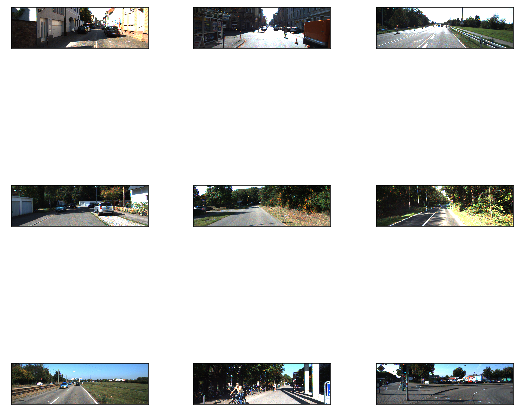

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/ssac21/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
         

## 1.2. 데이터 직접 확인하기
- 데이터 하나 뽑아서 확인
- 이미지 위에 바운딩 박스 그리기

In [5]:
TakeDataset = ds_train.take(1)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-1.34,  2.2 ,  1.8 ,  1.42, -1.94, -0.82,  2.85,  2.7 , -0.1 ,
        3.02], dtype=float32)>, 'bbox': <tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[0.26491892, 0.7202451 , 0.50845945, 0.7618546 ],
       [0.0027027 , 0.21377452, 0.53294593, 0.4166585 ],
       [0.29108107, 0.57593954, 0.50164866, 0.6105392 ],
       [0.39218917, 0.25806373, 0.5259189 , 0.270866  ],
       [0.39935136, 0.27347222, 0.514973  , 0.2870915 ],
       [0.40216216, 0.54532677, 0.50637835, 0.5735866 ],
       [0.39786488, 0.3814951 , 0.5214054 , 0.39456698],
       [0.40545946, 0.3731536 , 0.50975674, 0.38813725],
       [0.40745947, 0.5715278 , 0.51454055, 0.5824183 ],
       [0.38383785, 0.5882925 , 0.49227026, 0.6070833 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[1.81, 0.65, 1.63],
       [1.7 , 0.6 , 1.7 ],

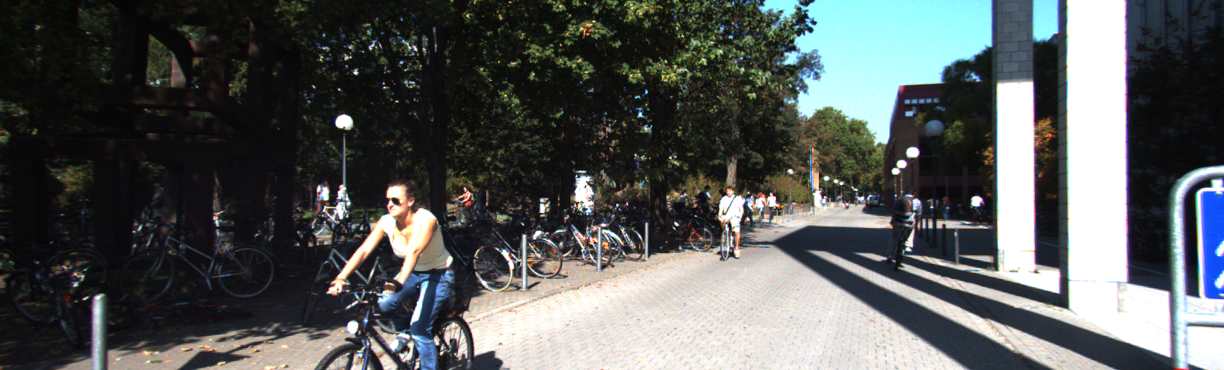

In [6]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1224  height: 370
(10, 4)
[881.58    271.97998 932.51    181.87001]
[261.66    369.      509.99    172.81001]
[704.95 262.3  747.3  184.39]
[315.87    224.89    331.53998 175.41   ]
[334.73    222.23999 351.4     179.45999]
[667.48    221.2     702.07    182.64001]
[466.94998 222.79    482.94998 177.08   ]
[456.74 219.98 475.08 181.39]
[699.55    219.23999 712.88    179.62   ]
[720.07 227.98 743.07 187.86]
<PIL.Image.Image image mode=RGB size=1224x370 at 0x7FF8507E64D0>


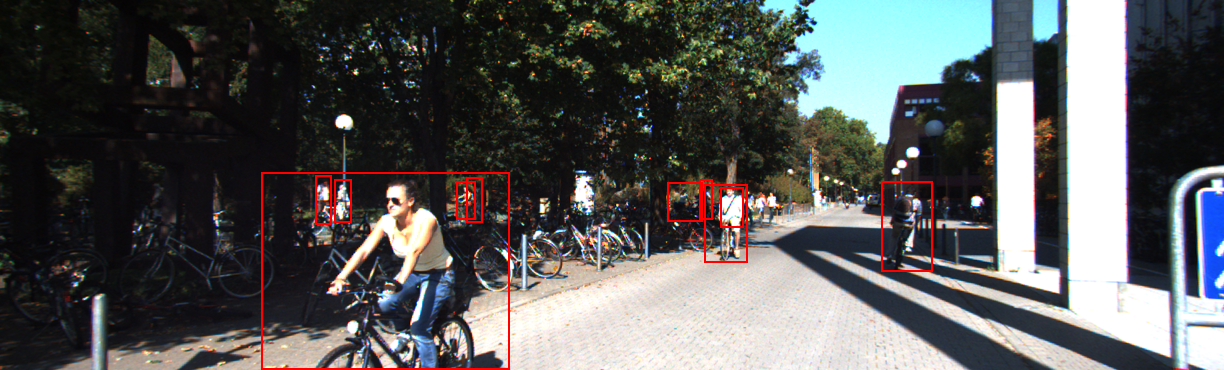

In [7]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

# 2. keras-retinanet 학습
## 2.1. 데이터 포맷 변경
### 클래스 및 바운딩 박스 정보 추출
- tensorflow_dataset의 API를 사용해 이미지와 각 이미지에 해당하는 바운딩 박스 라벨의 정보를 얻을 수 있었습니다.
- 이를 활용하여 한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 CSV 파일을 생성합니다.

In [12]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는 parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [15:15<00:00,  6.93it/s]


In [13]:
# 테스트 데이터셋에도 동일 과정 적용
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:40<00:00,  7.10it/s]


### 클래스 맵핑
- 각 클래스를 숫자 인덱스에 맵핑

In [14]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

## 2.2. 학습
- 변환한 데이터셋으로 학습 진행
- 환경에 따라 batch_size나 worker, epoch 조절

In [8]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다.
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-13 15:15:47.508981: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-13 15:15:48.616145: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-13 15:15:48.621167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-13 15:15:48.621747: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-13 15:15:48.621768: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-13 15:15:48.622959: I tensorflow/stream_executor/platform

Epoch 1/50
2021-04-13 15:16:01.265334: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-04-13 15:16:02.746359: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2021-04-13 15:16:02.778405: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-04-13 15:16:03.052450: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
195/195 [==============================] - ETA: 0s - loss: 3.4835 - regression_loss: 2.6542 - classification_loss: 0.8292
Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
195/195 [==============================] - 57s 291ms/step - loss: 3.4835 - regression_loss: 2.6542 - classification_loss: 0.82

195/195 [==============================] - ETA: 0s - loss: 1.4158 - regression_loss: 1.0938 - classification_loss: 0.3220
Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5
195/195 [==============================] - 57s 295ms/step - loss: 1.4158 - regression_loss: 1.0938 - classification_loss: 0.3220
Epoch 17/50
195/195 [==============================] - ETA: 0s - loss: 1.3711 - regression_loss: 1.0626 - classification_loss: 0.3085
Epoch 00017: saving model to ./snapshots/resnet50_csv_17.h5

Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
195/195 [==============================] - 58s 295ms/step - loss: 1.3711 - regression_loss: 1.0626 - classification_loss: 0.3085
Epoch 18/50
195/195 [==============================] - ETA: 0s - loss: 1.1941 - regression_loss: 0.9209 - classification_loss: 0.2732
Epoch 00018: saving model to ./snapshots/resnet50_csv_18.h5
195/195 [==============================] - 58s 297ms/step - loss: 1.1941 - regression_loss:

195/195 [==============================] - ETA: 0s - loss: 1.0264 - regression_loss: 0.7781 - classification_loss: 0.2482
Epoch 00032: saving model to ./snapshots/resnet50_csv_32.h5
195/195 [==============================] - 58s 295ms/step - loss: 1.0264 - regression_loss: 0.7781 - classification_loss: 0.2482
Epoch 33/50
195/195 [==============================] - ETA: 0s - loss: 1.0489 - regression_loss: 0.7976 - classification_loss: 0.2513
Epoch 00033: saving model to ./snapshots/resnet50_csv_33.h5

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.99999943962493e-12.
195/195 [==============================] - 58s 296ms/step - loss: 1.0489 - regression_loss: 0.7976 - classification_loss: 0.2513
Epoch 34/50
195/195 [==============================] - ETA: 0s - loss: 1.1216 - regression_loss: 0.8618 - classification_loss: 0.2598
Epoch 00034: saving model to ./snapshots/resnet50_csv_34.h5
195/195 [==============================] - 57s 295ms/step - loss: 1.1216 - regression_loss: 

195/195 [==============================] - ETA: 0s - loss: 0.9871 - regression_loss: 0.7459 - classification_loss: 0.2412
Epoch 00048: saving model to ./snapshots/resnet50_csv_48.h5
195/195 [==============================] - 57s 294ms/step - loss: 0.9871 - regression_loss: 0.7459 - classification_loss: 0.2412
Epoch 49/50
195/195 [==============================] - ETA: 0s - loss: 1.0068 - regression_loss: 0.7627 - classification_loss: 0.2440
Epoch 00049: saving model to ./snapshots/resnet50_csv_49.h5
195/195 [==============================] - 57s 292ms/step - loss: 1.0068 - regression_loss: 0.7627 - classification_loss: 0.2440
Epoch 50/50
195/195 [==============================] - ETA: 0s - loss: 1.0355 - regression_loss: 0.7871 - classification_loss: 0.2485
Epoch 00050: saving model to ./snapshots/resnet50_csv_50.h5

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.999999010570977e-19.
195/195 [==============================] - 57s 294ms/step - loss: 1.0355 - regression_loss:

In [9]:
# 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환합니다.
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-13 16:05:37.136994: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-13 16:05:38.889518: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-13 16:05:38.894980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-13 16:05:38.895562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-13 16:05:38.895584: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-13 16:05:38.899182: I tensorflow/stream_executor/platform

## 2.3. 시각화
- 변환한 모델 load
- 추론 및 시각화

In [8]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

work_dir = os.getenv('HOME')+'/aiffel/object_detection'
model_path = os.path.join(work_dir, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


In [12]:
# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_0.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0)  # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:  # 일정 점수 이하는 제외
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()

[591.1141  174.3885  624.77515 205.32661]
[194.9393  129.46318 353.29752 226.0319 ]


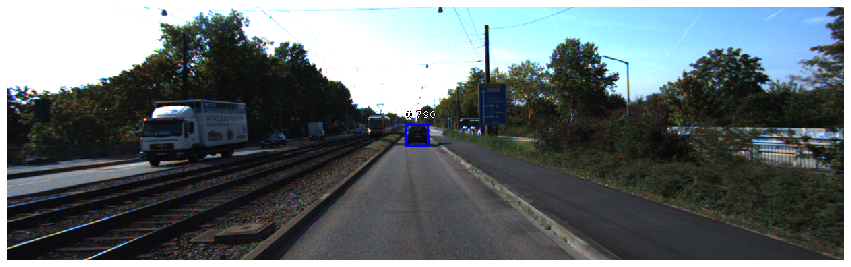

In [13]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'
inference_on_image(model=model, img_path=img_path)

# 3. 자율주행 보조 시스템 만들기
## 3.1. 자율주행 시스템 만들기
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.
- 입력으로 이미지 경로를 받습니다.
- 다음 정지조건에 맞는 경우 "Stop", 아닌 경우 "Go"를 반환합니다.
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우

In [27]:
def self_drive_assist(model, img_path, size_limit=300, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0)  # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if visualize:
        result = 'Go'
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.4:  # 일정 점수 이하는 제외
                break
            b = box.astype(int)
            w = b[2]-b[0]
            h = b[3]-b[1]
            
            if w >= size_limit or h >= size_limit or label == 1:
                result = 'Stop'
            else:
                result = 'Go'
            
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
        
        return result

[417.59393 160.90295 498.13257 332.21338]
[417.25766 161.73767 494.29837 335.4646 ]


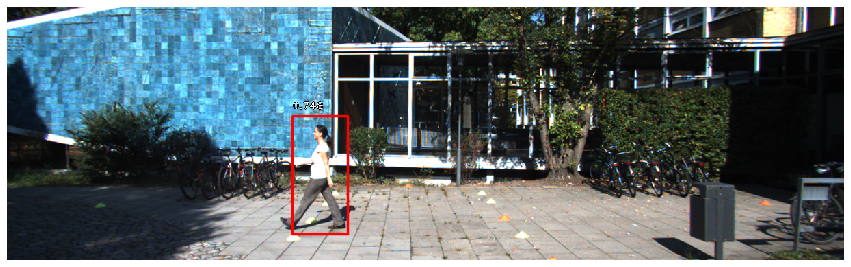

'Stop'

In [28]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_2.png'
self_drive_assist(model=model, img_path=img_path)

## 3.2. 자율주행 시스템 평가하기
아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [29]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = self_drive_assist(model=model, img_path=image_path)
        print(image_file)
        print(f'prediction: {pred}, answer: {answer}\n')
        if pred == answer:
            score += 10
    print(f"결과: {score}점입니다.")

[770.9821  146.21474 841.0803  317.70374]
[773.1815  148.54306 845.96204 314.43967]


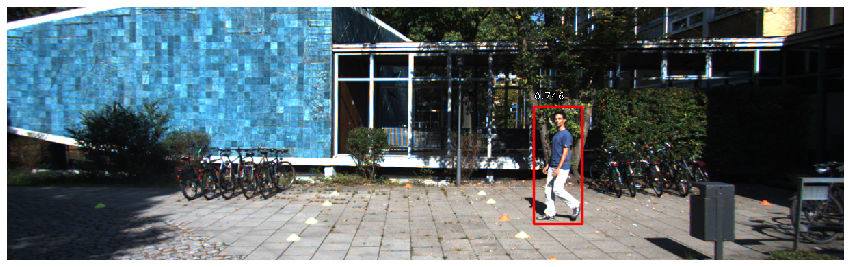

test_set/stop_1.png
prediction: Stop, answer: Stop

[417.59393 160.90295 498.13257 332.21338]
[417.25766 161.73767 494.29837 335.4646 ]


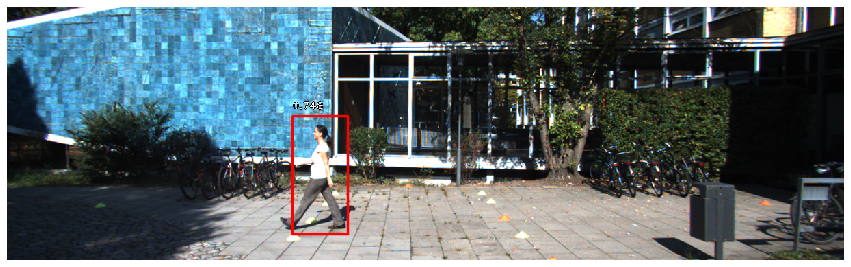

test_set/stop_2.png
prediction: Stop, answer: Stop

[  2.5503197 203.21101   296.3986    369.12827  ]
[760.6993  161.91063 888.8449  210.99933]


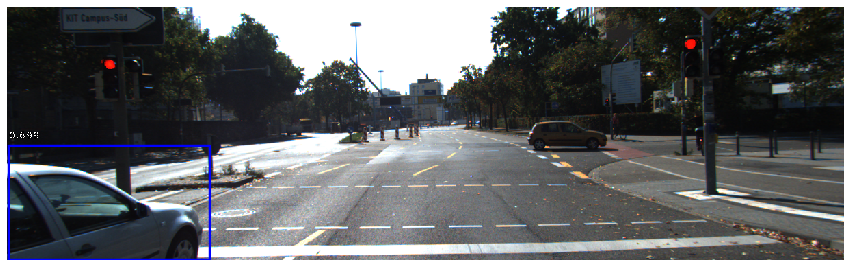

test_set/stop_3.png
prediction: Go, answer: Stop

[ 704.8956    84.13526 1117.4547   373.6249 ]
[117.783646 162.69211  377.67767  305.32062 ]


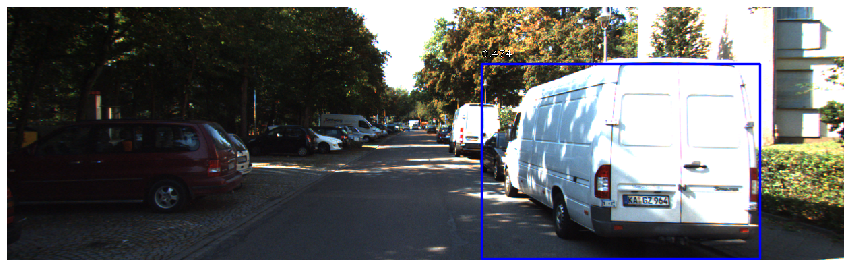

test_set/stop_4.png
prediction: Stop, answer: Stop

[ 871.96484  174.40819 1236.062    371.32553]
[736.25653 165.61491 860.6396  243.95102]


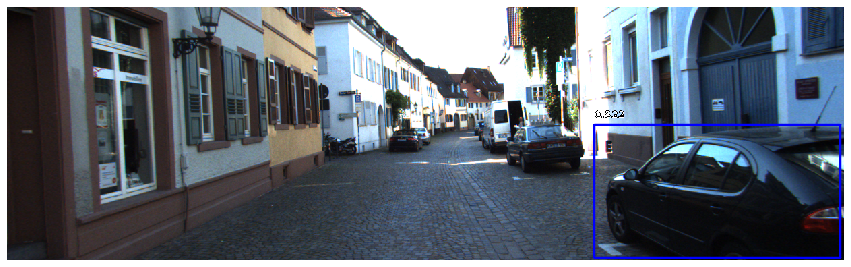

test_set/stop_5.png
prediction: Stop, answer: Stop

[591.1141  174.3885  624.77515 205.32661]
[194.9393  129.46318 353.29752 226.0319 ]


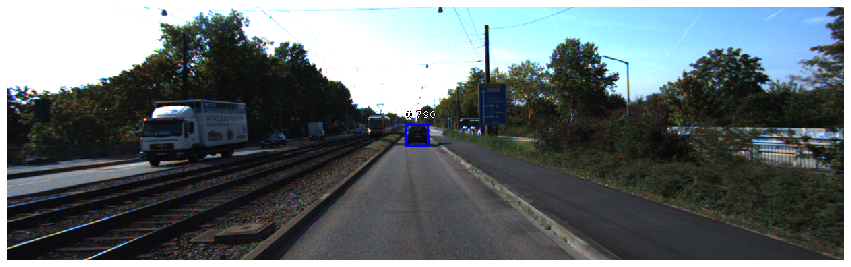

test_set/go_1.png
prediction: Go, answer: Go

[625.93207 175.27266 669.8992  214.02336]
[516.73425 175.72325 564.94794 212.4523 ]


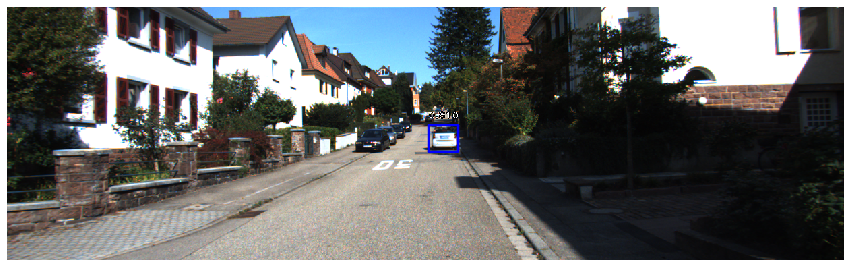

test_set/go_2.png
prediction: Go, answer: Go

[809.9203  146.4422  891.54785 177.81207]
[801.33966 129.04283 896.4619  172.37756]


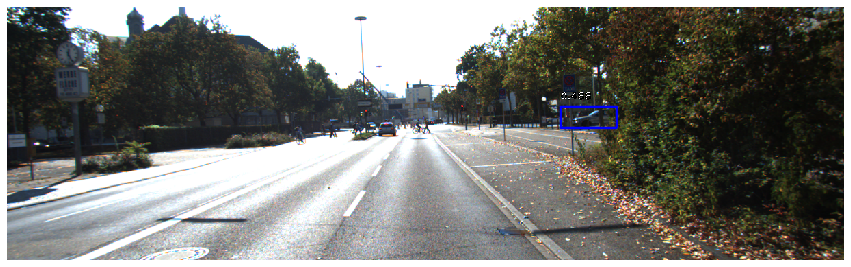

test_set/go_3.png
prediction: Go, answer: Go

[694.2873  171.10469 795.5718  251.32939]
[666.52325 125.33082 811.5637  250.45575]


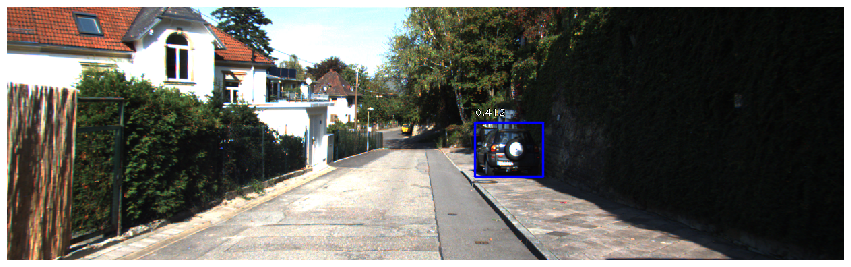

test_set/go_4.png
prediction: Go, answer: Go

[ 15.385454 190.46808  221.94283  307.72617 ]
[183.871   186.64787 338.53275 260.53204]


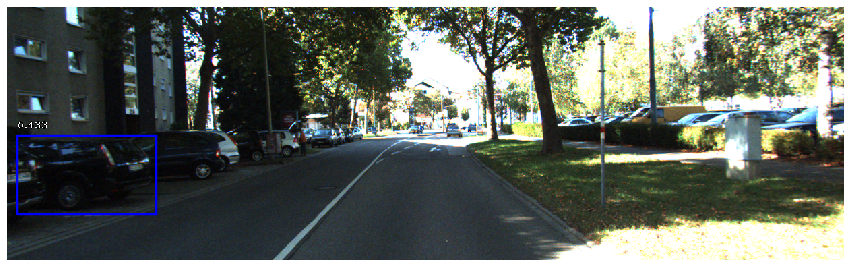

test_set/go_5.png
prediction: Go, answer: Go

결과: 90점입니다.


In [30]:
test_system(self_drive_assist)

***
- `self_drive_assist()` 함수의 default 리턴 값을 'Go'로 설정하여 기본적으로 주행을 하되 정지 조건을 만족하는 상황에선 'Stop'을 리턴하도록 구현했다.
- 초기 테스트에서는 이미지 2장을 틀리게 예측하여 80점이 나왔다. 이후 score threshold 값을 0.5에서 0.4로 낮추고 다시 테스트하니 점수가 90점으로 올랐다.